In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from utils.plotting import prediction_error_plot
import torch

In [3]:
stations = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/IEA_PVPS_europe.zarr')
sarah = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SARAH3_new.zarr')

In [4]:
print(stations.station_name.values)

['CAB' 'CAR' 'CEN' 'MIL' 'NOR' 'PAL' 'PAY' 'TAB' 'TOR' 'VIS']


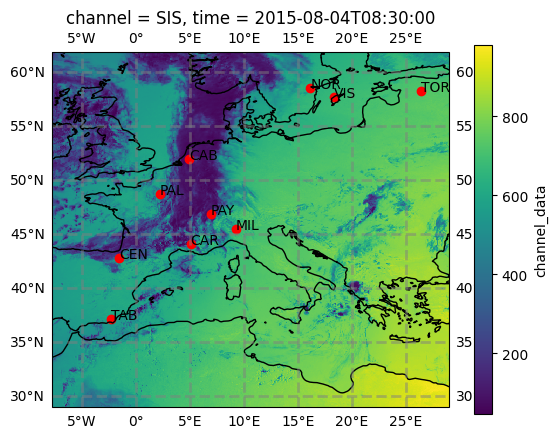

In [5]:
proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.latitude.values
lon = stations.longitude.values
name = stations.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

sarah.channel_data.sel(channel='SIS').isel(time = 10310).plot.imshow(ax=axis, transform = proj)

In [6]:
def sarah_predictions(station, time_window=12):
    print(station, ' Start')
    lat = stations.sel(station_name=station).latitude.data
    lon = stations.sel(station_name=station).longitude.values
    ilat = (np.abs(sarah.lat - lat)).argmin().values
    ilon = (np.abs(sarah.lon - lon)).argmin().values
    rolling = stations.sel(station_name=station) \
            .rolling(time=time_window,center=False) \
            .mean().dropna(dim='time')
    # rolling average of X minutes (seviri takes X min to create an image, RSS=5min, normal full disk 12min)
    # mean becomes a nan if a single nan value is encountered in GHI

    # mean index is the right most index -> convert to left most index to relate to hrseviri
    rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')

    print('sarah samples',len(sarah.time))
    print('station samples', len(rolling.time))
    timenotnan = set(rolling.time.values).intersection(set(sarah.time.values))
    timenotnan = np.sort(np.array(list(timenotnan)))
    print('collocated time-averaged samples:', len(timenotnan))
    
    sarah_timeseries = sarah.sel(time=timenotnan).isel(lat=ilat, lon=ilon)
    CAB_timeseries = rolling.sel(time=timenotnan)
    y = CAB_timeseries.GHI.values
    y_hat = sarah_timeseries.channel_data.sel(channel='SIS').values
    combined = xarray.merge([sarah_timeseries, CAB_timeseries])
    return y, y_hat, combined

In [7]:
predictions_stations = {nm: sarah_predictions(nm) for nm in stations.station_name.values}
predictions_stations = {nm: {'y': p[0], 'y_hat':p[1], 'combined': p[2]} for nm, p in predictions_stations.items()} 


CAB  Start
sarah samples 139915
station samples 888632
collocated time-averaged samples: 29462
CAR  Start
sarah samples 139915
station samples 765942
collocated time-averaged samples: 25397
CEN  Start
sarah samples 139915
station samples 720466
collocated time-averaged samples: 23789
MIL  Start
sarah samples 139915
station samples 782465
collocated time-averaged samples: 25926
NOR  Start
sarah samples 139915
station samples 1271881
collocated time-averaged samples: 42235
PAL  Start
sarah samples 139915
station samples 1246560
collocated time-averaged samples: 41422
PAY  Start
sarah samples 139915
station samples 570339
collocated time-averaged samples: 18943
TAB  Start
sarah samples 139915
station samples 1568798
collocated time-averaged samples: 52212
TOR  Start
sarah samples 139915
station samples 681132
collocated time-averaged samples: 22601
VIS  Start
sarah samples 139915
station samples 1176106
collocated time-averaged samples: 39077


CAB: 	 mean err: -2	 std err: 77 	 median err: 3 	 R2score: 0.892
CAR: 	 mean err: 6	 std err: 74 	 median err: 8 	 R2score: 0.915
CEN: 	 mean err: -1	 std err: 89 	 median err: 4 	 R2score: 0.885
MIL: 	 mean err: 14	 std err: 74 	 median err: 11 	 R2score: 0.928
NOR: 	 mean err: -6	 std err: 75 	 median err: -5 	 R2score: 0.89
PAL: 	 mean err: 4	 std err: 82 	 median err: 4 	 R2score: 0.896
PAY: 	 mean err: -18	 std err: 80 	 median err: -7 	 R2score: 0.898
TAB: 	 mean err: 2	 std err: 77 	 median err: -3 	 R2score: 0.935
TOR: 	 mean err: -11	 std err: 91 	 median err: -6 	 R2score: 0.822
VIS: 	 mean err: -12	 std err: 100 	 median err: -9 	 R2score: 0.848


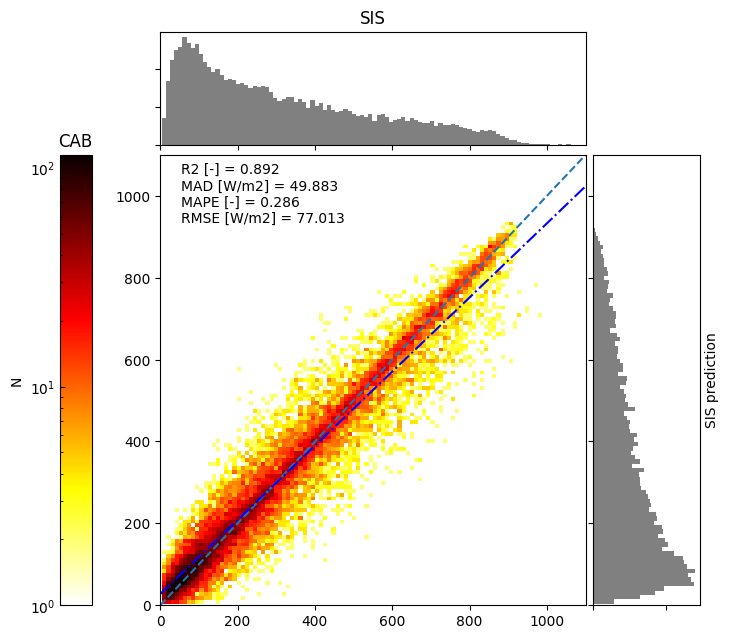

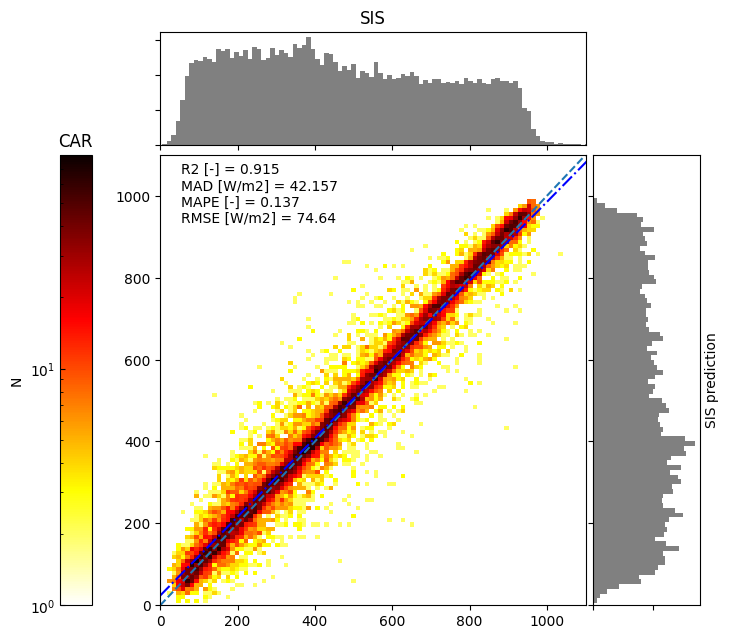

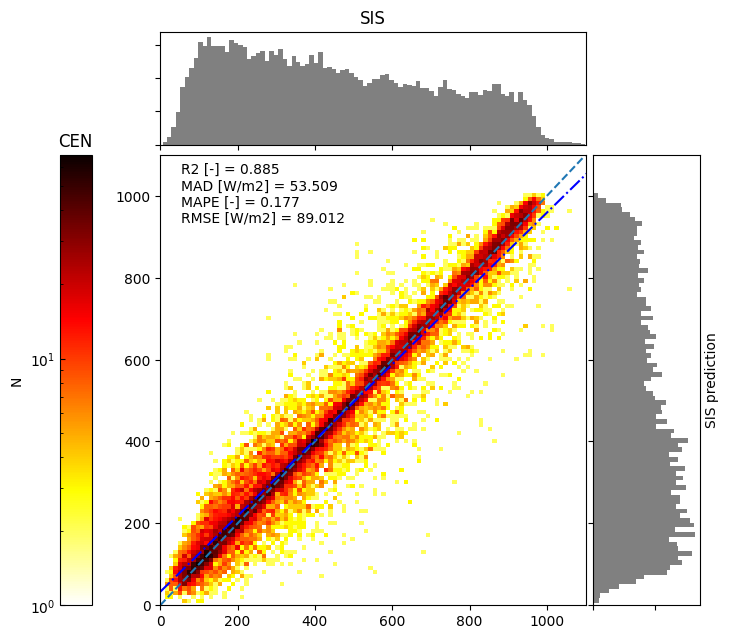

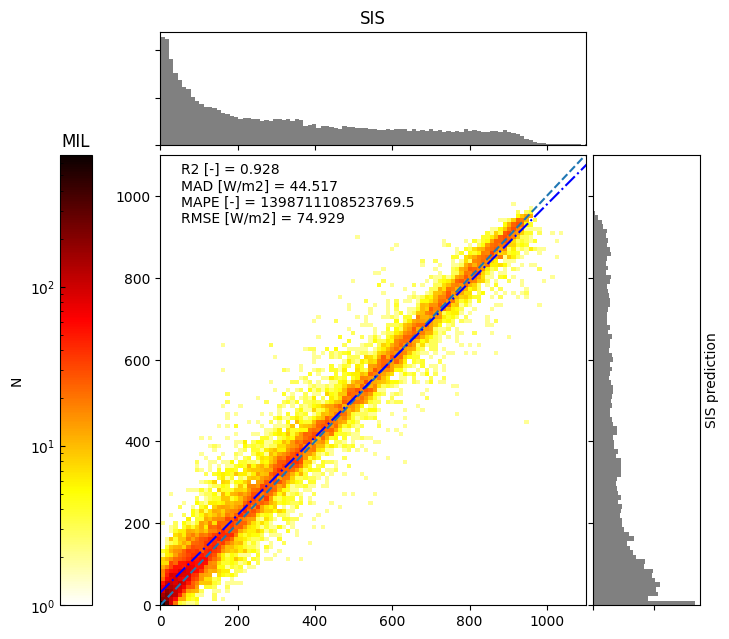

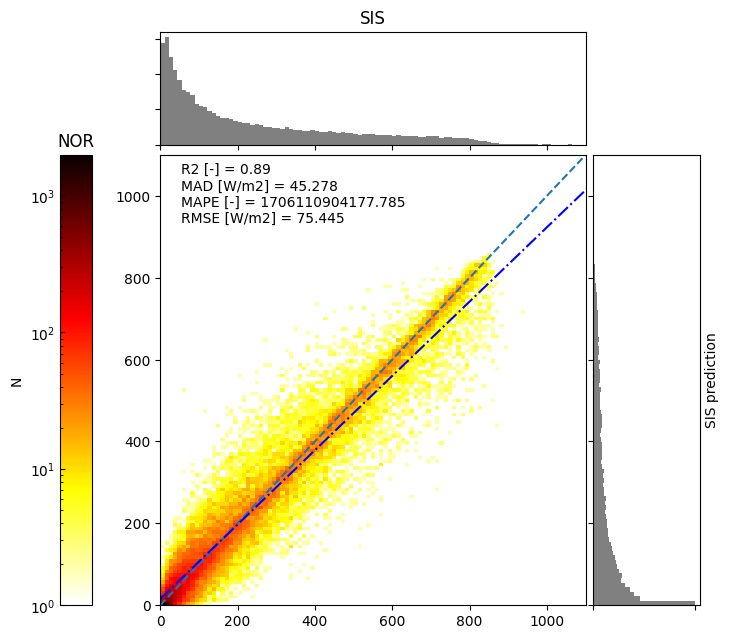

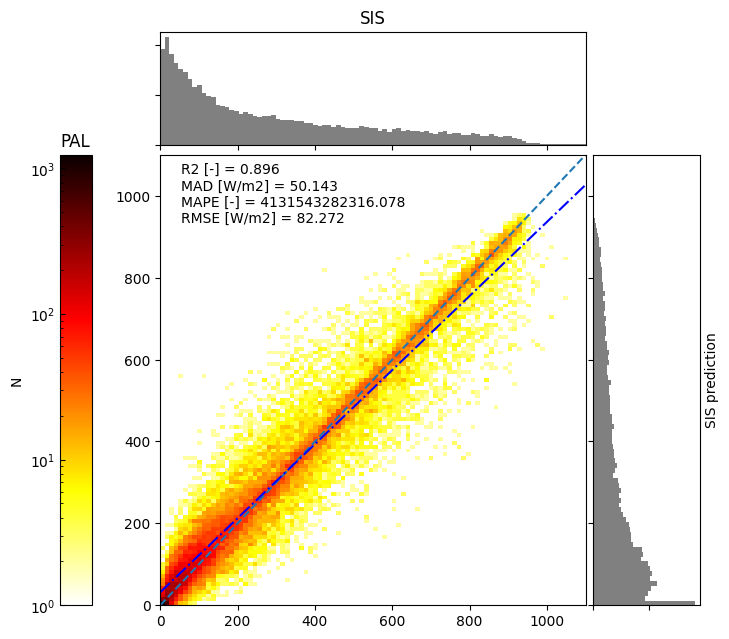

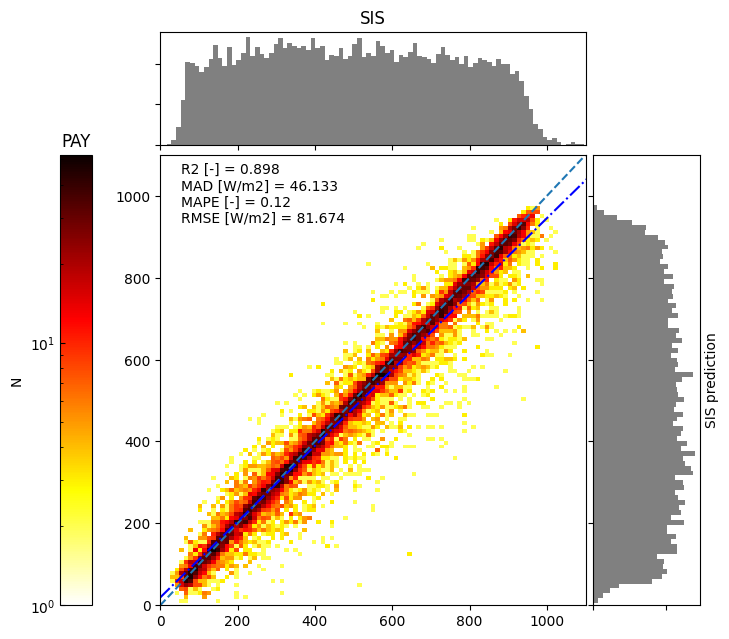

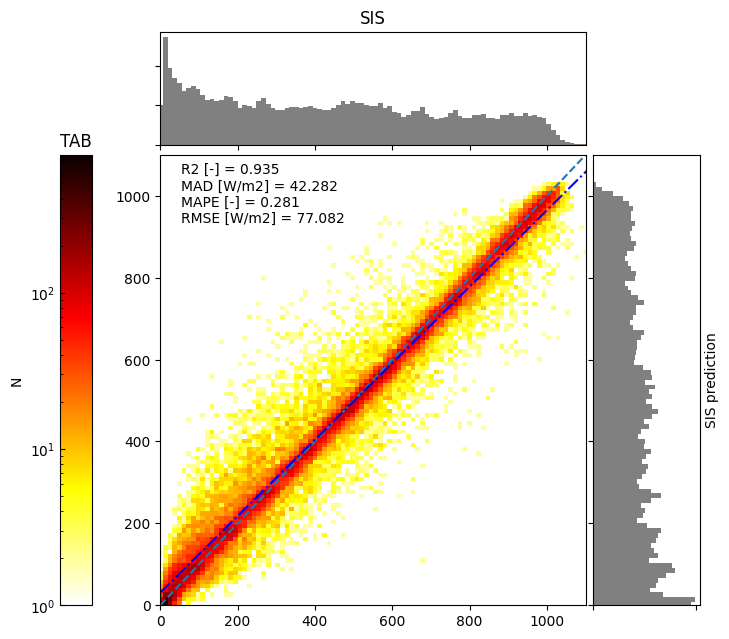

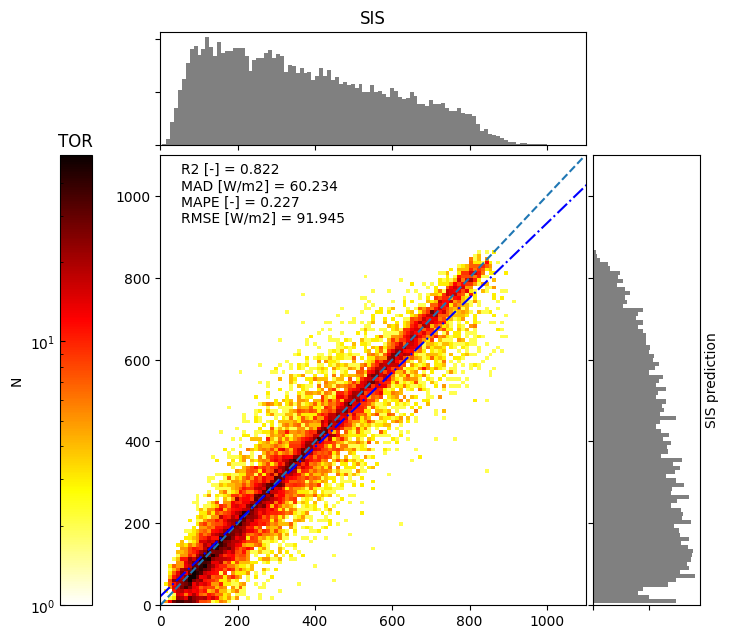

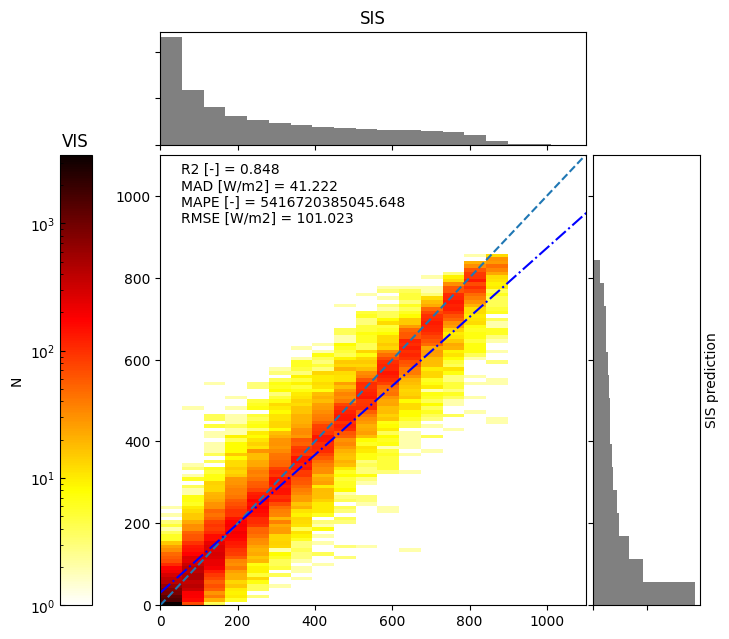

In [10]:
from torchmetrics import R2Score

r2score = R2Score()

for key, val in predictions_stations.items():
    y_hat = val['y_hat'].astype(np.float64)
    y = val['y'].astype(np.float64)
    error = torch.tensor(y_hat - y)
    mean = torch.nanmean(error).item()
    std = torch.std(error).item()
    median = torch.nanmedian(error).item()
    R2 = r2score(torch.tensor(y_hat, dtype = torch.double), torch.tensor(y, dtype=torch.double)).item()
    print(f"{key}: \t mean err: {round(mean)}\t std err: {round(std)} \t median err: {round(median)} \t R2score: {round(R2, 3)}")
    fig = prediction_error_plot(y, y_hat, title=key)
    fig.savefig(f'error_prediction_plot_baseline_{key}.png')

